In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import sys

# Add the directory containing `pokie.py` to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

# Import pokie from pokie.py
from pokie import pokie

In [2]:
runs_probability = []
# Generate input data
N = 100
x = np.linspace(0, 10, N)
A = np.vstack((x, np.ones(N))).T  # Design matrix

# Number of samples from the posterior
num_samples = 100
num_gt = 100

# Define multiple ground truth parameters (slope and intercept values)
ground_truths = []

for t in tqdm(range(0, num_gt), desc='Generating Ground Truths'):
    curr_m = np.random.uniform(-5, 5)
    curr_b = np.random.uniform(-1, 1)

    # Store GT such that ground_truths is 5x2
    ground_truths.append([curr_m, curr_b])

# List of noise levels
noise_levels = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]

# Prior mean and covariance
mu_0 = np.array([0.0, 0.0])
Sigma_0 = np.array([[10.0, 0.0],
                    [0.0, 10.0]])

# Initialize a container for posteriors
posteriors = np.zeros((len(noise_levels), len(ground_truths), num_samples, 2))

# Loop over ground truths and noise levels
for g_idx in tqdm(range(len(ground_truths)), desc='Generating Posterior Samples'):
    # Extract ground truth parameters
    m_true = ground_truths[g_idx][0]
    b_true = ground_truths[g_idx][1]
    theta_true = np.array([m_true, b_true])

    # Loop over each noise level
    for n_idx, sigma_noise in enumerate(noise_levels):
        Sigma_n = sigma_noise ** 2 * np.eye(N)
        
        # Generate observed data with Gaussian noise
        y = A @ theta_true + np.random.normal(0, sigma_noise, N)
        
        # Compute posterior covariance
        Sigma_post_inv = np.linalg.inv(Sigma_0) + A.T @ np.linalg.inv(Sigma_n) @ A
        Sigma_post = np.linalg.inv(Sigma_post_inv)
        
        # Compute posterior mean
        mu_post = Sigma_post @ (np.linalg.inv(Sigma_0) @ mu_0 + A.T @ np.linalg.inv(Sigma_n) @ y)
        
        # Sample from the multivariate normal posterior
        posterior_samples = np.random.multivariate_normal(mu_post, Sigma_post, num_samples)
        
        # Store the posterior samples
        posteriors[n_idx, g_idx, :, :] = posterior_samples

ground_truths = np.array(ground_truths)
print(f'Ground Truths: {ground_truths.shape}')
print(f'Posterior Shape: {posteriors.shape}')  # Should be (5, 6, 100, 2)

Generating Posterior Samples: 100%|██████████| 100/100 [00:00<00:00, 206.30it/s]

Ground Truths: (100, 2)
Posterior Shape: (6, 100, 100, 2)


# Verify Noise Level is Correctly Added

In [3]:
# Example: Check posterior means for a GT far from [0,0]
g_idx = np.argmax(np.linalg.norm(ground_truths - [0,0], axis=1))
print("GT:", ground_truths[g_idx])
for n_idx in range(len(noise_levels)):
    print(f"Noise {noise_levels[n_idx]}: Mean = {posteriors[n_idx, g_idx].mean(axis=0)}")

GT: [-4.9280516   0.89859996]
Noise 0.001: Mean = [-4.92804178  0.89862983]
Noise 0.01: Mean = [-4.92863538  0.9027454 ]
Noise 0.1: Mean = [-4.92486455  0.88348175]
Noise 0.15: Mean = [-4.92827907  0.89137338]
Noise 0.2: Mean = [-4.9248665   0.88628861]
Noise 0.25: Mean = [-4.91714407  0.84268778]


# Plot Not Normalized Data

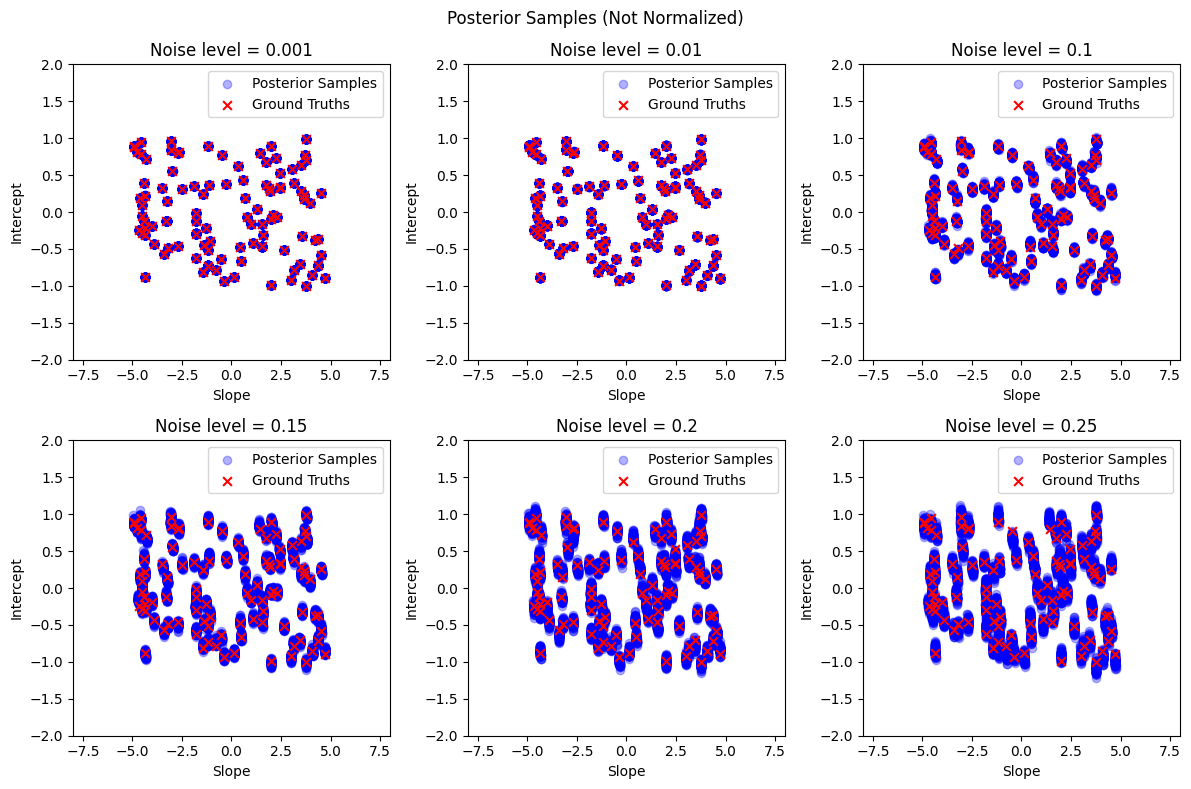

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you already have:
#   ground_truths.shape = (num_gt, 2)
#   posteriors.shape = (num_noise_levels, num_gt, num_samples, 2)
#   noise_levels = [0.001, 0.01, 0.1, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 cols
axes = axes.flatten()  # Flatten so we can index from 0..5 easily

for i, noise_level in enumerate(noise_levels):
    ax = axes[i]

    # Flatten the posterior samples at this noise level across all ground truths.
    # shape = (num_gt * num_samples, 2)
    posterior_points = posteriors[i].reshape(-1, 2)

    # Plot the posterior samples
    ax.scatter(
        posterior_points[:, 0],
        posterior_points[:, 1],
        alpha=0.3,
        color='blue',
        label='Posterior Samples'
    )

    # Option 1: Plot all ground truths (if not too many)
    ax.scatter(
        ground_truths[:, 0],
        ground_truths[:, 1],
        c='red',
        marker='x',
        s=40,
        label='Ground Truths'
    )

    # Option 2 (alternative): Plot just one ground truth, for example the 0th:
    # ax.scatter(
    #     ground_truths[0, 0],
    #     ground_truths[0, 1],
    #     c='red',
    #     marker='x',
    #     s=100,
    #     label='Ground Truth'
    # )

    ax.set_title(f'Noise level = {noise_level}')
    ax.set_xlabel('Slope')
    ax.set_ylabel('Intercept')
    ax.legend(loc='best')

    # Set x lim to be -5 to 5 and y lim to be - 2 to 2
    ax.set_xlim(-8, 8)
    ax.set_ylim(-2, 2)
fig.suptitle('Posterior Samples (Not Normalized)')
fig.tight_layout()
plt.show()

# Normalization

In [5]:
num_noise_levels, num_gt, num_samples, d = posteriors.shape
# (Should be (6, 100, 100, 2) in your current setup.)

# 1) Create a list of arrays
all_points_list = []

# Add ground truths (shape = (num_gt, 2))
all_points_list.append(ground_truths)

# Flatten each model’s posterior samples: shape => (num_gt * num_samples, 2)
for noise_i in range(num_noise_levels):
    flat_posterior = posteriors[noise_i].reshape(-1, d)
    all_points_list.append(flat_posterior)

# 2) Concatenate them
all_points = np.concatenate(all_points_list, axis=0)  # shape => (some_number, 2)

# 3) Compute global min & max across each dimension
global_min = np.min(all_points, axis=0)  # shape (2,)
global_max = np.max(all_points, axis=0)  # shape (2,)

epsilon = 1e-12
scale = global_max - global_min
scale[scale == 0.0] = epsilon  # handle any zero range

# 1) Normalize the ground truths
ground_truths_norm = (ground_truths - global_min) / scale

# 2) Allocate a container for the normalized posteriors
posteriors_norm = np.zeros_like(posteriors)

# 3) Loop over noise levels and reshape
for noise_i in range(num_noise_levels):
    # Flatten shape => (num_gt * num_samples, 2)
    flat_posterior = posteriors[noise_i].reshape(-1, d)
    
    # Normalize
    flat_posterior_norm = (flat_posterior - global_min) / scale
    
    # Reshape back => (num_gt, num_samples, 2)
    posteriors_norm[noise_i] = flat_posterior_norm.reshape(num_gt, num_samples, d)

# Plot Normalized

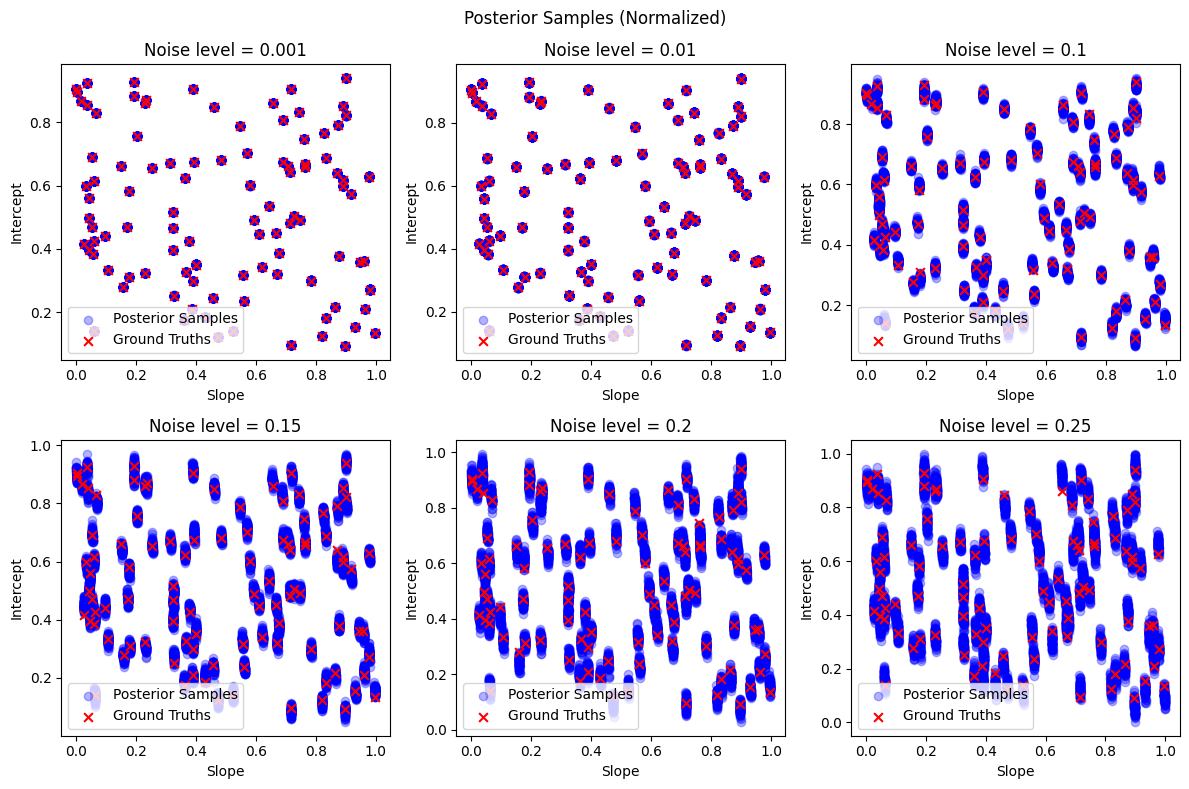

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you already have:
#   ground_truths.shape = (num_gt, 2)
#   posteriors.shape = (num_noise_levels, num_gt, num_samples, 2)
#   noise_levels = [0.001, 0.01, 0.1, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 cols
axes = axes.flatten()  # Flatten so we can index from 0..5 easily

for i, noise_level in enumerate(noise_levels):
    ax = axes[i]

    # Flatten the posterior samples at this noise level across all ground truths.
    # shape = (num_gt * num_samples, 2)
    posterior_points = posteriors_norm[i].reshape(-1, 2)

    # Plot the posterior samples
    ax.scatter(
        posterior_points[:, 0],
        posterior_points[:, 1],
        alpha=0.3,
        color='blue',
        label='Posterior Samples'
    )

    # Option 1: Plot all ground truths (if not too many)
    ax.scatter(
        ground_truths_norm[:, 0],
        ground_truths_norm[:, 1],
        c='red',
        marker='x',
        s=40,
        label='Ground Truths'
    )

    # Option 2 (alternative): Plot just one ground truth, for example the 0th:
    # ax.scatter(
    #     ground_truths_norm[0, 0],
    #     ground_truths_norm[0, 1],
    #     c='red',
    #     marker='x',
    #     s=100,
    #     label='Ground Truth'
    # )

    ax.set_title(f'Noise level = {noise_level}')
    ax.set_xlabel('Slope')
    ax.set_ylabel('Intercept')
    ax.legend(loc='best')

    # Set x lim to be -5 to 5 and y lim to be - 2 to 2
    # ax.set_xlim(-8, 8)
    # ax.set_ylim(-2, 2)
# Title for the entire figure
fig.suptitle('Posterior Samples (Normalized)')
fig.tight_layout()
plt.show()

# Pokie - Not Normalized

100%|██████████| 100/100 [00:00<00:00, 114.72it/s]


Shape of total_probability: (100, 6)
Results: [0.20445235 0.16129631 0.15859368 0.16156546 0.1572107  0.1568815 ]
Best Model Index: 0


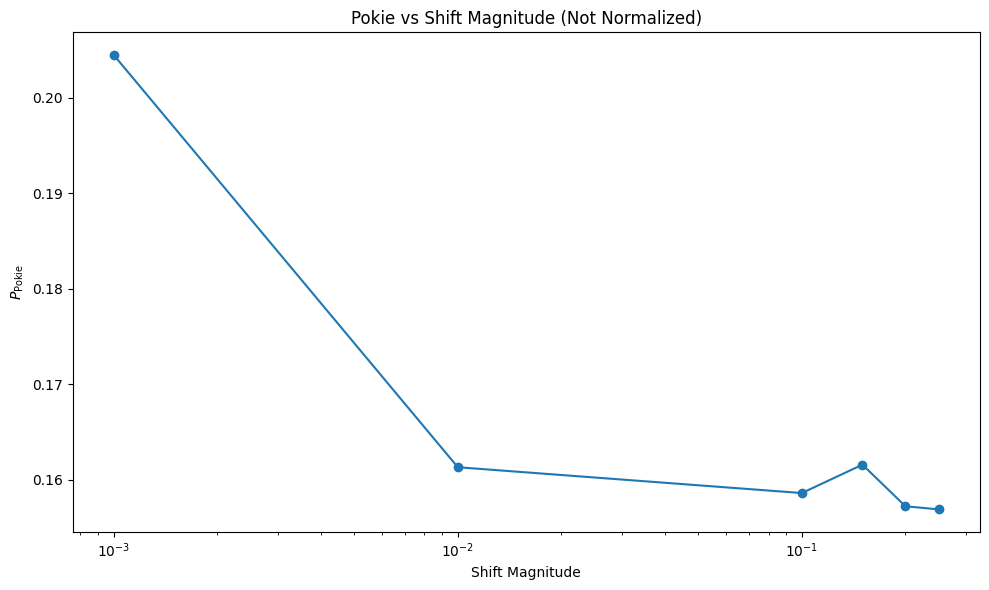

In [7]:
results = pokie(ground_truths, posteriors)
print('Results:', results)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Shift Magnitude')
plt.ylabel(r'$P_{\text{Pokie}}$')
plt.title('Pokie vs Shift Magnitude (Not Normalized)')
# Make x ticks the noise levels
plt.xticks(noise_levels)
# LOG SCALE X AXIS
plt.xscale('log')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 417.71it/s]


Individual Model Results: [array([0.8546]), array([0.5619505]), array([0.50628317]), array([0.50080891]), array([0.50915941]), array([0.50057822])]
Best Model Index: 0


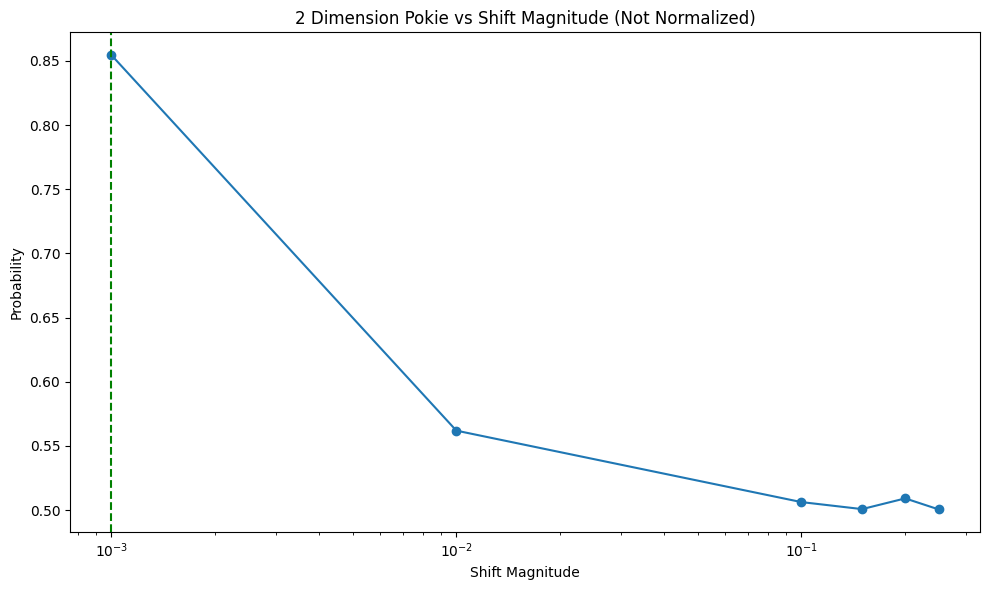

In [8]:
# Loop through GMM models & pass it to pokie and plot the results
results = []
for i in range(len(posteriors)):
    curr_model = posteriors[i]
    curr_model = curr_model[np.newaxis, :, :, :] # This might be the bug 
    curr_results = pokie(ground_truths_norm, curr_model, num_runs = 100)
    results.append(curr_results)

print(f'Individual Model Results: {results}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude (Not Normalized)')
plt.xticks(noise_levels)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=noise_levels[best_model_idx], color='g', linestyle='--')
plt.xscale('log')
plt.tight_layout()
plt.show()

# Pokie - Normalized

100%|██████████| 100/100 [00:00<00:00, 112.22it/s]


Shape of total_probability: (100, 6)
Results: [0.20768895 0.16490114 0.15569061 0.15869442 0.15632237 0.15670251]
Best Model Index: 0


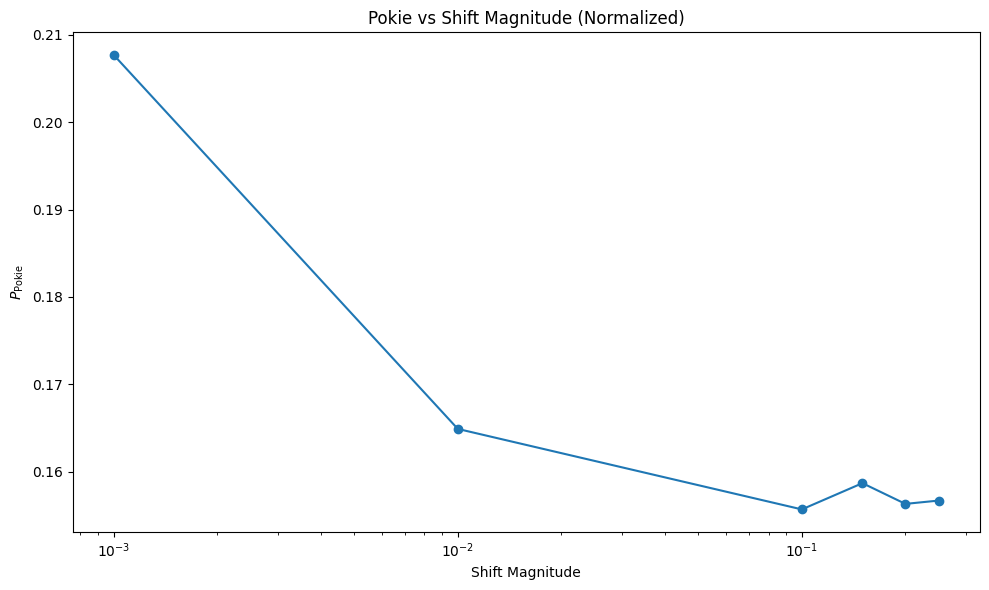

In [9]:
results = pokie(ground_truths_norm, posteriors_norm)
print('Results:', results)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Shift Magnitude')
plt.ylabel(r'$P_{\text{Pokie}}$')
plt.title('Pokie vs Shift Magnitude (Normalized)')
# Make x ticks the noise levels
plt.xticks(noise_levels)
# LOG SCALE X AXIS
plt.xscale('log')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 472.10it/s]


Individual Model Results: [array([0.87520396]), array([0.69821287]), array([0.65381386]), array([0.6717495]), array([0.66265149]), array([0.65864356])]
Best Model Index: 0


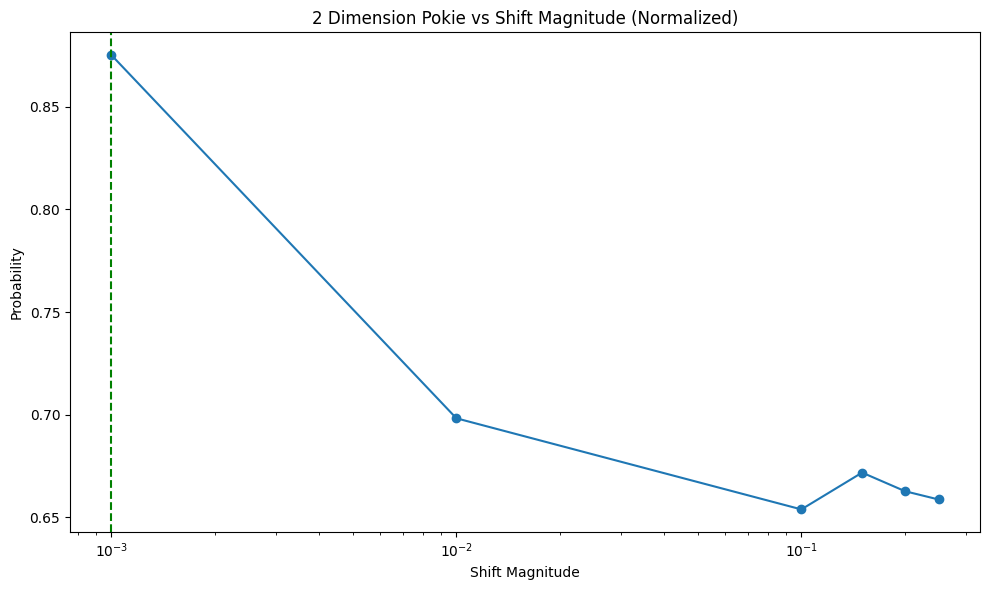

In [11]:
# Loop through GMM models & pass it to pokie and plot the results
results = []
for i in range(len(posteriors_norm)):
    curr_model = posteriors_norm[i]
    curr_model = curr_model[np.newaxis, :, :, :] # This might be the bug 
    curr_results = pokie(ground_truths_norm, curr_model, num_runs = 100)
    results.append(curr_results)

print(f'Individual Model Results: {results}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude (Normalized)')
plt.xticks(noise_levels)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=noise_levels[best_model_idx], color='g', linestyle='--')
plt.xscale('log')
plt.tight_layout()
plt.show()

# Show Noise Model 0 & Pokie to see what's happening

In [ ]:
def plot_data(truth, posterior):
    # Validate shapes
    num_truth, dim = truth.shape
    num_models, truth_check, num_posterior_samples, dim_check = posterior.shape

    if num_truth != truth_check:
        raise ValueError("Number of truth samples doesn't match the second dimension of posterior.")
    if dim != dim_check:
        raise ValueError("Parameter dimension of truth doesn't match that of posterior.")

    total_probability = []

    # Generate random centers: (num_truth, dim)
    centers = np.random.uniform(low=0, high=1, size=(num_truth, dim))

    # Probability array to fill: (num_models, num_truth)
    probability = np.zeros((num_models, num_truth))

    # Loop over each truth sample i
    for i in range(num_truth):
        curr_truth = truth[i]
        curr_center = centers[i]

        # Precompute squared distance between center & truth for k-check
        theta_gt_dist_sq = np.sqrt(np.sum((curr_center - curr_truth) ** 2))

        if i == 0:
            print(f'Truth: {curr_truth}')
            print(f'Center: {curr_center}')
            print(f'Truth Distance: {theta_gt_dist_sq:.3f}')

        # Loop over each model j
        for j in range(num_models):
            curr_posterior = posterior[j, i]  # shape: (num_posterior_samples, dim)

            # Pick one random sample index
            idx = np.random.randint(low=0, high=len(curr_posterior))
            random_sample = curr_posterior[idx]
            # Create a mask to exclude the chosen sample
            mask = np.ones(len(curr_posterior), dtype=bool)
            mask[idx] = False

            # Compute squared distance between center & random sample
            theta_dist_sq = np.sqrt(np.sum((curr_center - random_sample) ** 2)) + 1e-4

            # Compute squared distance to *all* remaining posterior points
            dist_sq_to_posterior = np.sqrt(np.sum((curr_center - curr_posterior[mask]) ** 2, axis=1)) # shape: (num_posterior_samples - 1,)

            # Determine k by comparing the truth distance vs. random sample distance
            if theta_gt_dist_sq <= theta_dist_sq:
                curr_k = 1
            else:
                curr_k = 0

            # Count how many posterior samples lie within the radius set by random_sample
            n = np.sum(dist_sq_to_posterior < theta_dist_sq)
            N = len(curr_posterior) - 1

            if curr_k == 1:
                curr_prob = (n + 1) / ((N + 2) * (N + 1))
            else:
                curr_prob = (N - n + 1) / ((N + 2) * (N + 1))
            if i == 0:
                print(f'K = {curr_k}, n = {n}, N = {N}, Pokie Probability = {curr_prob:.7f}')
            curr_prob = curr_prob
            if i == 0:
                temp = curr_prob * (N + 1)
                print(f'K = {curr_k}, n = {n}, N = {N}, New Pokie Probability = {temp:.7f}')

            # Count how many posterior samples lie within the radius set by random_sample
            n = np.sum(dist_sq_to_posterior < theta_dist_sq)
            N = len(curr_posterior) - 1

            if i == 0:
                # Plot the center
                plt.scatter(curr_center[0], curr_center[1], c='red', marker='x', label='Center')
                
                # Plot the circle around the center to the random sample
                circle = plt.Circle(curr_center, theta_dist_sq, color='blue', fill=False)
                plt.gca().add_artist(circle)

                # Plot the curr posterior samples
                plt.scatter(curr_posterior[:, 0], curr_posterior[:, 1], c='green', alpha=0.3, label='Posterior Samples')
                # Plot the random sample
                plt.scatter(random_sample[0], random_sample[1], c='blue', marker='x', label='Random Sample')

                # Plot the current ground truth
                plt.scatter(curr_truth[0], curr_truth[1], c='red', marker='o', label='Ground Truth')
                # Title
                plt.title(f'Noise Level = {noise_levels[j]} n = {n}, N = {N}, k = {curr_k} \n Pokie Probability = {curr_prob:.3f}')
                plt.legend()
                # Set x lim to be -5 to 5 and y lim to be - 2 to 2
                plt.xlim(-5, 5)
                plt.ylim(-2, 2)
                plt.tight_layout()
                plt.show()

            if i != 0:
                continue


    return None

plot_data(ground_truths, posteriors)

In [10]:
# # Make a 2x2 grid of plots with all the same ground truths and centers but different posterior samples
# fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 cols

# for i, noise_level in enumerate(noise_levels):
#     ax = axes[i // 3, i % 3]

#     # Make a circle centered on the center and  the radius of the random sample
#     circle = plt.Circle(centers[i], store_theta_dist_sq[i], color='green', fill=False, label='Theta Distances')
#     ax.add_artist(circle)
#     # Plot the first ground truth
#     ax.scatter(ground_truths[0, 0], ground_truths[0, 1], c='purple', alpha = 0.7, label='Ground Truth')
#     # Plot the first posterior sample for noise level index 0
#     ax.scatter(posteriors[i, 0, :, 0], posteriors[i, 0, :, 1], c='orange', alpha = 1.0, label='Posterior Sample')
#     # Plot the first center
#     ax.scatter(centers[i, 0], centers[i, 1], c='red', label='Centers')
#     # Plot the first random sample
#     ax.scatter(store_random_sample[i, 0], store_random_sample[i, 1], c='blue', alpha = 0.7, label='Random Sample')
#     # Make y lim to be -5 to 5
#     ax.set_ylim(-5, 5)
#     ax.set_xlim(-3, 3)
#     ax.legend()

# plt.tight_layout()
# plt.show()